In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy import stats
from patsy import dmatrices

import matplotlib.pyplot as plt

# Problem współliniowości

### Diagnostyka

1. **Macierz korelacji predyktorów** - $D_X = (\rho_{ij})$;

2. **Uwarunkowanie macierzy** $\frac{\lambda_{\text{max}}(D_X)}{\lambda_{\text{min}}(D_X)}$ - duże $\implies$ istnieje para predyktorów zależnych liniowo;

3. **VIF** (ang. *variance inflation factor*) - współczynnik podbicia wariancji

    Dla $1\leq i \leq p-1$: $$R^2_i = \frac{\text{RSS}}{\text{TSS}}$$ dla modelu $x_i \sim x_{-i}$, gdzie $x_{-i}$ oznacza wszystkie zmienne objaśniające z  pominięciem $i$-tej.

    Wówczas
    $$
    \text{VIF}_i = \frac{1}{1-R_i^2}
    $$

    **Interpretacja:** Duża wartość dla pewnego $i$ wskazuje na potencjalną liniową zależność $i$-tej zmiennej objaśniającej od pozostałych zmiennych.

    **Reguła kciuka:** Jeśli $\text{VIF}_i\geq 10$, to $i$-tą zmienną uznajemy w przybliżeniu liniowo zależną od pozostałych.

# Zadanie 1
Dla danych `Carseats` sprawdź, czy występuje w nich problem współliniowości przy użyciu powyższych metod. Jeśli tak, odrzuć ze zbioru zmienne zależne liniowo i dopasuj model regresji liniowej bez nich. Porównaj wyniki.

In [4]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)
carseats_df = carseats.data
carseats_df = pd.get_dummies(carseats_df,columns = ['ShelveLoc','Urban','US'],drop_first=True)
carseats_df

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,False,False,True,True
1,11.22,111,48,16,260,83,65,10,True,False,True,True
2,10.06,113,35,10,269,80,59,12,False,True,True,True
3,7.40,117,100,4,466,97,55,14,False,True,True,True
4,4.15,141,64,3,340,128,38,13,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,33,14,True,False,True,True
396,6.14,139,23,3,37,120,55,11,False,True,False,True
397,7.41,162,26,12,368,159,40,18,False,True,True,True
398,5.94,100,79,7,284,95,50,12,False,False,True,True


In [3]:
#X ma być bez Sales
Xvar = carseats_df.loc[:, ~carseats_df.columns.isin(['Sales'])]
Xvar

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,False,False,True,True
1,111,48,16,260,83,65,10,True,False,True,True
2,113,35,10,269,80,59,12,False,True,True,True
3,117,100,4,466,97,55,14,False,True,True,True
4,141,64,3,340,128,38,13,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14,True,False,True,True
396,139,23,3,37,120,55,11,False,True,False,True
397,162,26,12,368,159,40,18,False,True,True,True
398,100,79,7,284,95,50,12,False,False,True,True


In [5]:
# macierz korelacji
features = Xvar.columns[np.arange(0,7)] #tylko ciągłe zmienne bierzemy
correlation_matrix = Xvar[features].corr()
print(correlation_matrix)

             CompPrice    Income  Advertising  Population     Price       Age  \
CompPrice     1.000000 -0.080653    -0.024199   -0.094707  0.584848 -0.100239   
Income       -0.080653  1.000000     0.058995   -0.007877 -0.056698 -0.004670   
Advertising  -0.024199  0.058995     1.000000    0.265652  0.044537 -0.004557   
Population   -0.094707 -0.007877     0.265652    1.000000 -0.012144 -0.042663   
Price         0.584848 -0.056698     0.044537   -0.012144  1.000000 -0.102177   
Age          -0.100239 -0.004670    -0.004557   -0.042663 -0.102177  1.000000   
Education     0.025197 -0.056855    -0.033594   -0.106378  0.011747  0.006488   

             Education  
CompPrice     0.025197  
Income       -0.056855  
Advertising  -0.033594  
Population   -0.106378  
Price         0.011747  
Age           0.006488  
Education     1.000000  


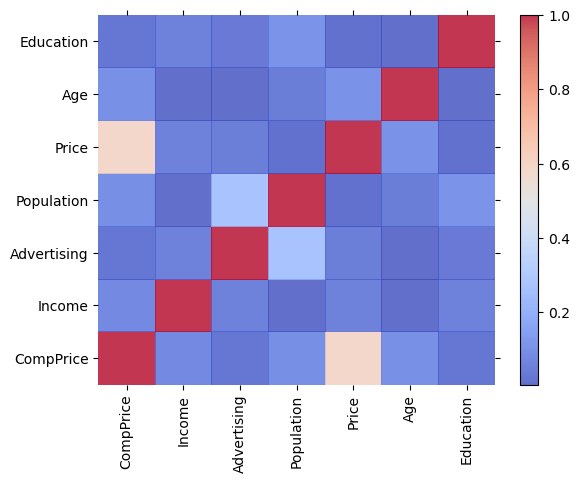

In [6]:
#zrobimy heatmapę od wartości bezwzględnych 0 - brak koralcji,  1-mocna korelacja
import matplotlib as mpl
heatmap = plt.pcolor(np.abs(correlation_matrix), cmap=mpl.cm.coolwarm, alpha=0.8)

heatmap.axes.set_frame_on(False)
heatmap.axes.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5, minor=False)
heatmap.axes.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5, minor=False)
heatmap.axes.set_xticklabels(features, minor=False)
plt.xticks(rotation=90)
heatmap.axes.set_yticklabels(features, minor=False)
plt.tick_params(axis='both', which='both', bottom='off',
                    top='off', left='off', right='off')
plt.colorbar()
plt.show()

In [8]:
# tworzenie modelu regresji liniowej
y = carseats.data['Sales']
lm = LinearRegression()
lm.fit(Xvar.values,y)
lm.coef_

array([ 9.28153421e-02,  1.58028363e-02,  1.23095089e-01,  2.07877065e-04,
       -9.53579188e-02, -4.60451630e-02, -2.11018389e-02,  4.85018271e+00,
        1.95671481e+00,  1.22886397e-01, -1.84092825e-01])

In [12]:
Xvar

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,False,False,True,True
1,111,48,16,260,83,65,10,True,False,True,True
2,113,35,10,269,80,59,12,False,True,True,True
3,117,100,4,466,97,55,14,False,True,True,True
4,141,64,3,340,128,38,13,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14,True,False,True,True
396,139,23,3,37,120,55,11,False,True,False,True
397,162,26,12,368,159,40,18,False,True,True,True
398,100,79,7,284,95,50,12,False,False,True,True


In [11]:
# uzyjemy VIF
# ograniczamy sie do macierzy x
Xvif = add_constant(np.array(Xvar.values,dtype=float)) # dodaje kolumne jedynek
Xvif

array([[  1., 138.,  73., ...,   0.,   1.,   1.],
       [  1., 111.,  48., ...,   0.,   1.,   1.],
       [  1., 113.,  35., ...,   1.,   1.,   1.],
       ...,
       [  1., 162.,  26., ...,   1.,   1.,   1.],
       [  1., 100.,  79., ...,   0.,   1.,   1.],
       [  1., 134.,  37., ...,   0.,   1.,   1.]])

In [13]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xvif, i) for i in range(1,Xvif.shape[1])]
vif["features"] = Xvar.columns
vif

,VIF Factor,features
0,1.554618,CompPrice
1,1.024731,Income
2,2.103136,Advertising
3,1.145534,Population
4,1.537068,Price
5,1.021051,Age
6,1.026342,Education
7,1.511411,ShelveLoc_Good
8,1.517882,ShelveLoc_Medium
9,1.022705,Urban_Yes


In [ ]:
#jest ok, nie trzeba nic wyrzucać

In [ ]:
# najlepiej od tego zaczynac!

# Zadanie 2
Wczytaj dane `kc_house_data.csv` ([This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015](https://www.kaggle.com/harlfoxem/housesalesprediction/data)).

Dopasuj model `price ~ bathrooms + sqft_living + sqft_lot + sqft_above + sqft_basement + lat + long`, uwzględnij współliniowość predyktorów.

In [15]:
house = pd.read_csv('kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
columns = np.array(['bathrooms', 'sqft_living', 'sqft_lot',
                    'sqft_above', 'sqft_basement', 'lat', 'long'])
Xvar = house.loc[:, house.columns.isin(columns)]
y = house['price']

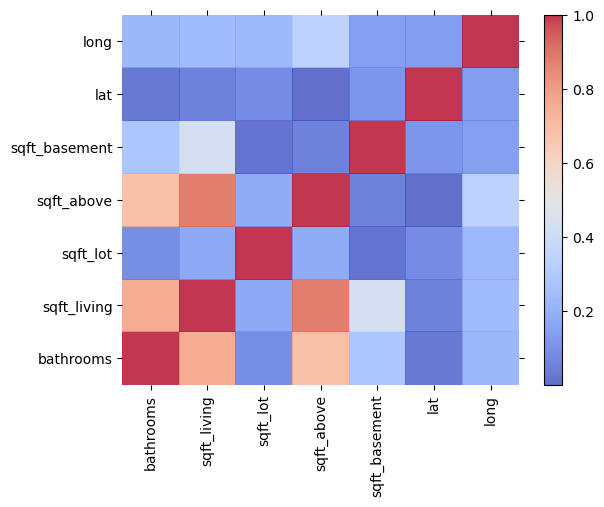

In [17]:
#heatmapa od wartości bezwzględnych korelacji - im bliżej 1 tym większe skorelowanie
correlation_matrix = house[columns].corr()
heatmap = plt.pcolor(np.abs(correlation_matrix),alpha =0.8,cmap=mpl.cm.coolwarm)
heatmap.axes.set_frame_on(False)
heatmap.axes.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5, minor=False)
heatmap.axes.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5, minor=False)
heatmap.axes.set_xticklabels(columns, minor=False)
plt.xticks(rotation=90)
heatmap.axes.set_yticklabels(columns, minor=False)
plt.tick_params(axis='both', which='both', bottom='off',
                    top='off', left='off', right='off')
plt.colorbar()
plt.show()


In [ ]:
# mamy zaleznosci ,ale nie mega 
# mozna sie zastanowic


In [ ]:
lm = LinearRegression()

In [23]:
lm.fit(Xvar.values,y)

LinearRegression()

In [24]:
Xvif = add_constant(np.array(Xvar.values,dtype=float)) # dodaje kolumne jedynek
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xvif, i) for i in range(1,Xvif.shape[1])]
vif["features"] = Xvar.columns
vif

C:\Users\BPE\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.357483,bathrooms
1,inf,sqft_living
2,1.084733,sqft_lot
3,inf,sqft_above
4,inf,sqft_basement
5,1.035092,lat
6,1.217042,long


In [ ]:
# ze wzgledu na inf w wynikach. sqt_living jest jednoznacznie opisywane przez sqrt_above, sqrt_basement

In [29]:
Xvar2 = Xvar.loc[:, ~Xvar.columns.isin(['sqft_living'])]

In [30]:
Xvif = add_constant(np.array(Xvar2.values,dtype=float)) # dodaje kolumne jedynek
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xvif, i) for i in range(1,Xvif.shape[1])]
vif["features"] = Xvar2.columns
vif

,VIF Factor,features
0,2.357483,bathrooms
1,1.084733,sqft_lot
2,2.302240,sqft_above
3,1.287468,sqft_basement
4,1.035092,lat
5,1.217042,long


# Zadanie 3
Wczytaj zbiór `Hald.csv`. Znajdź najlepszy model regresji liniowej uwzględniając współliniowość predyktorów.

Opis zbioru:

    Heat evolved during setting of 13 cement mixtures of four basic ingredients. Each ingredient percentage appears to be rounded down to a full integer. The sum of the four mixture percentages varies from a maximum of 99% to a minimum of 95%. If all four regressor X-variables always summed to 100%, the centered X-matrix would then be of rank only 3. Thus, the regression of heat on four X-percentages is ill-conditioned, with an approximate rank deficiency of MCAL = 1. The first column is the response and the remaining four columns are the predictors.

In [ ]:
# hald = pd.read_csv("Hald.csv")
# hald.head()

In [ ]:
# Xvar = hald.loc[:, hald.columns!='y']
# y = hald['y']